In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2') #binary_cl2_old_best, binary_cl2_4

In [4]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)

{'lr': 1e-06, 'lr_backbone': 1e-06, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.1, 'args.mini_batch_size': 32, 'num_hidden_layers': 1, 'dividing_factor': 20, 'output_channels_mlp': 256, 'n_channels1_cnn': 256, 'n_channels2_cnn': 512, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7f5d5816e590>, <dataset.data.SmartNegAugment object at 0x7f5d5816e410>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7f5c60128f10>, <dataset.data.SmartNegAugment object at 0x7f5c60129690>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'start_e

In [178]:
#args_dict['policies_train'][0].height_probabilities

In [179]:
#args_dict['policies_train'][0].height_bins

In [5]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_val_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_val_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [6]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'val500.csv'))

In [7]:
assert test500.couples.isin(gene_pairs_test).all()

In [8]:
res = pd.read_csv(os.path.join(checkpoint_dir, 'val_results500.csv'))

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70     30197
           1       0.39      0.42      0.40     14200

    accuracy                           0.60     44397
   macro avg       0.55      0.55      0.55     44397
weighted avg       0.61      0.60      0.60     44397



# PLOTS

### Log plots

In [98]:
#checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2')

# log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
# best_model = np.argmax(log.test_accuracy)
# for metric in ['loss', 'accuracy']:
#     plot_logs(log, metric, best_model = best_model)

## Metrics

In [9]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    28915
1    15482
Name: prediction, dtype: int64


0    30197
1    14200
Name: ground_truth, dtype: int64


In [10]:
n_conf = 10

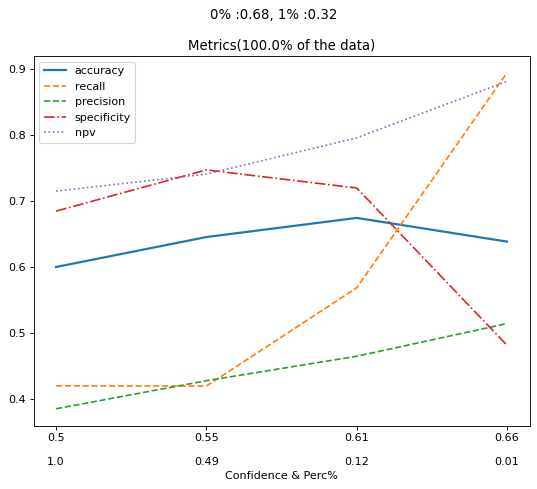

In [11]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

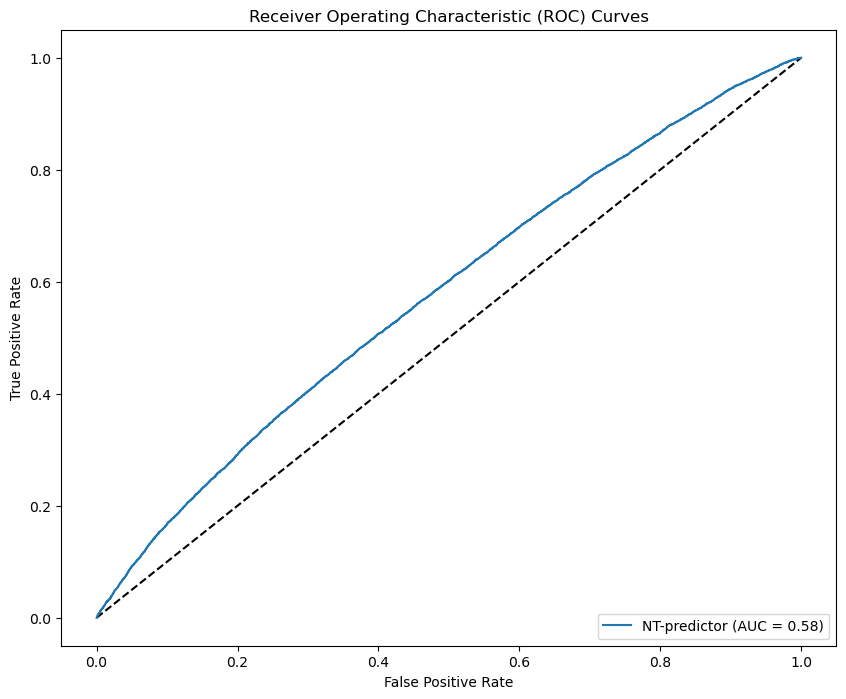

In [12]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT-predictor'}], res.ground_truth)

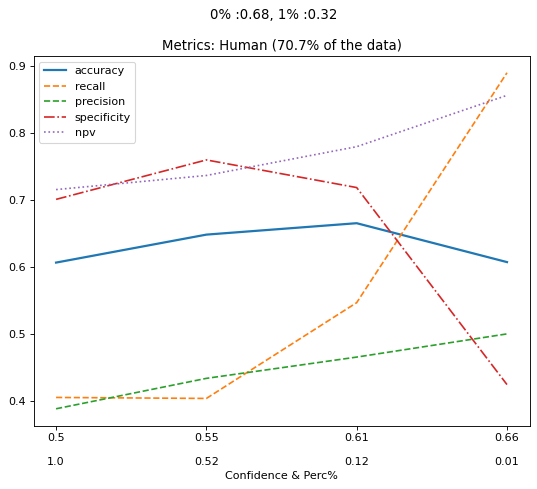

In [13]:
human = res[(res.specie == 'human')]
obtain_plot(human, n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

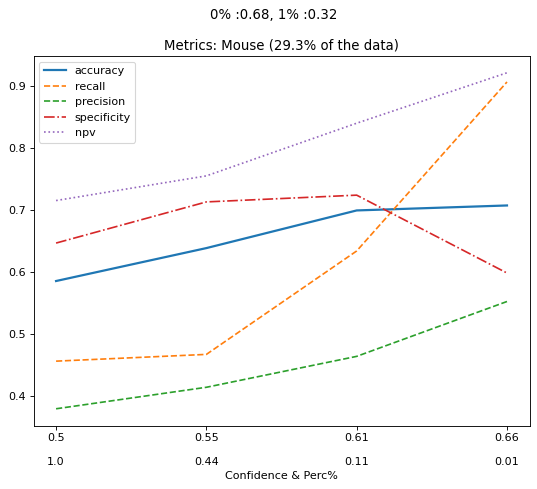

In [14]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(mouse, n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

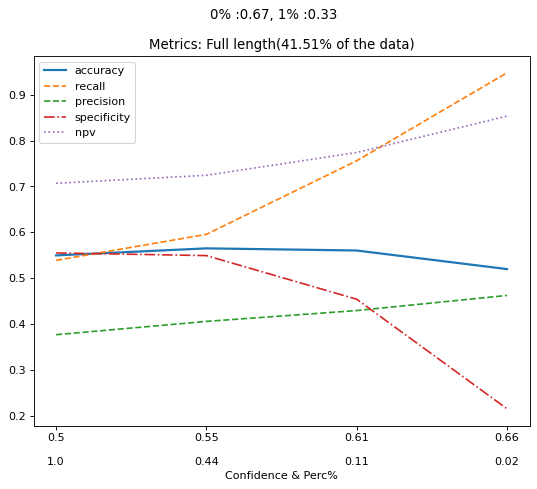

In [15]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(full_length, n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

In [16]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]

In [17]:
(high_conf_fl.ground_truth == high_conf_fl.prediction).sum() / high_conf_fl.shape[0]

0.5285087719298246

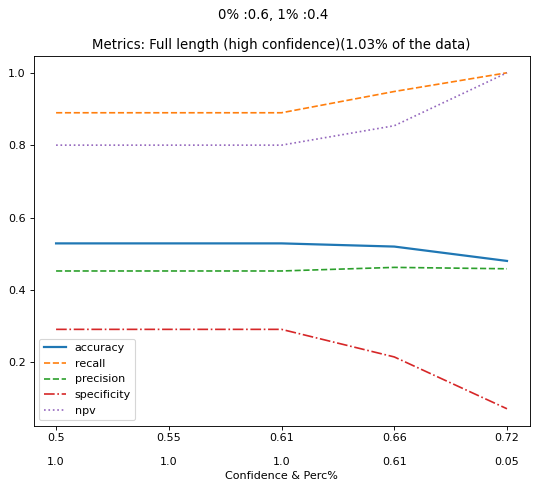

In [18]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(high_conf_fl, n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

In [109]:
# big_area_size = res.sampled_area.quantile(0.9)
# big_area_size = 5000**2
# big_area = res[res['sampled_area'] > big_area_size]

# obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

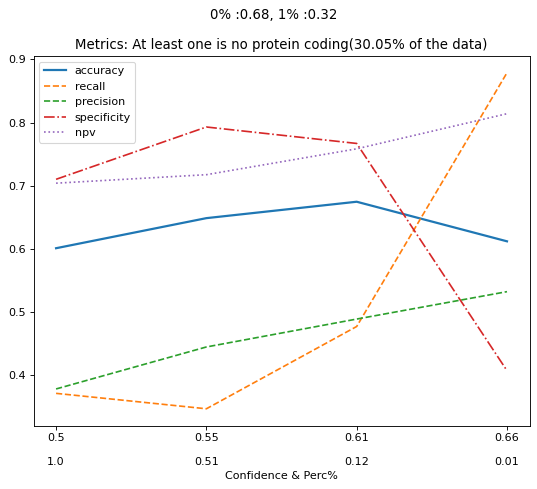

In [19]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

In [20]:
test = pd.read_csv(os.path.join(metadata_dir, f'val_sampled.csv'))
print(test.interacting.value_counts())
test = test[['id_gene1_sample', 'id_gene2_sample']]

True     14200
False    14200
Name: interacting, dtype: int64


In [21]:
res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

1    14212
0    14208
Name: ground_truth, dtype: int64

In [22]:
# subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt.txt")
# with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
#     subset_test_nt_sampled = pickle.load(fp)
    
# easypos_smartneg = res[res.id_sample.isin(subset_test_nt_sampled)]

0.5484517945109079


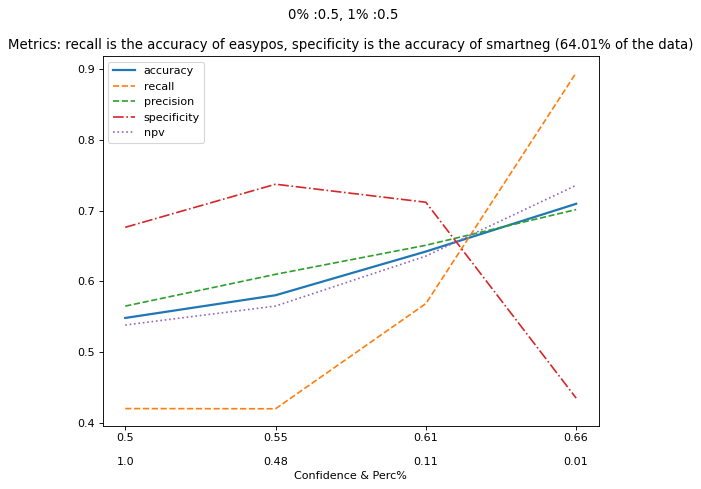

In [23]:
# vc = easypos_smartneg.ground_truth.value_counts()
# assert vc.loc[1] > vc.loc[0]
# n_to_exclude = vc.loc[1] - vc.loc[0]
# easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
# id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
# easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]

easypos_smartneg_sampled = easypos_smartneg
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)

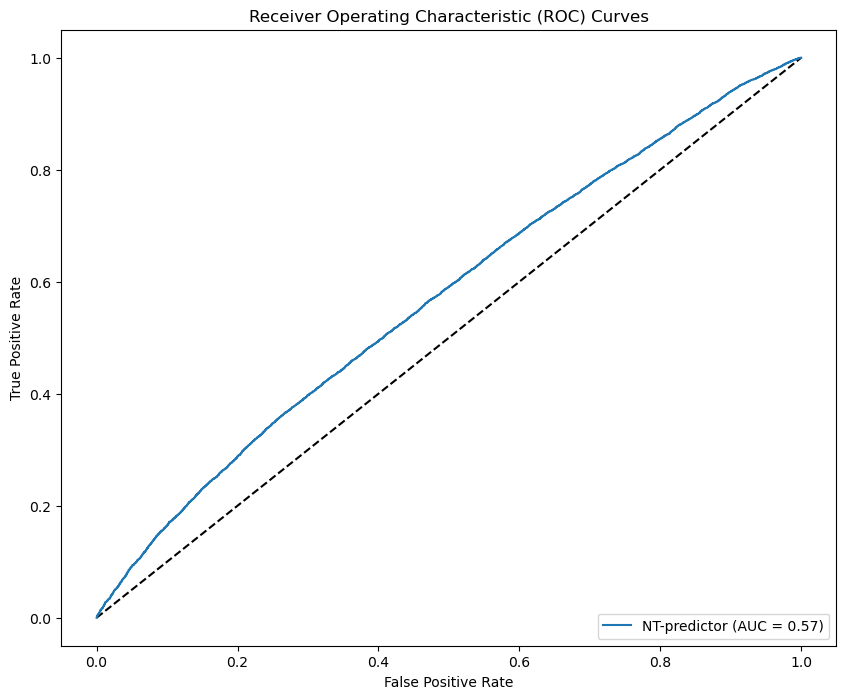

In [24]:
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT-predictor'}], easypos_smartneg_sampled.ground_truth)

0.8423373759647188


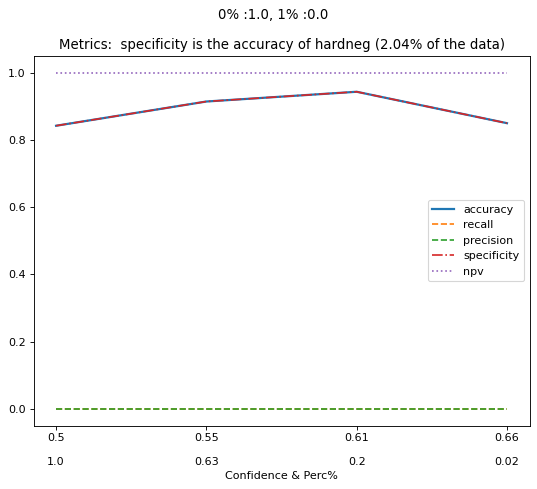

In [25]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.8727429062768701


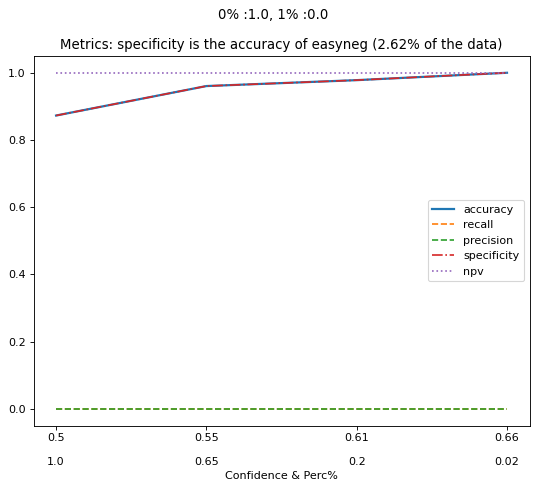

In [26]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

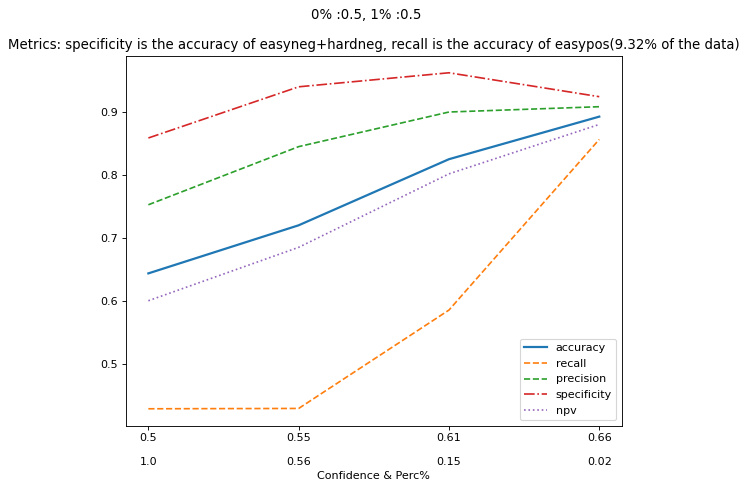

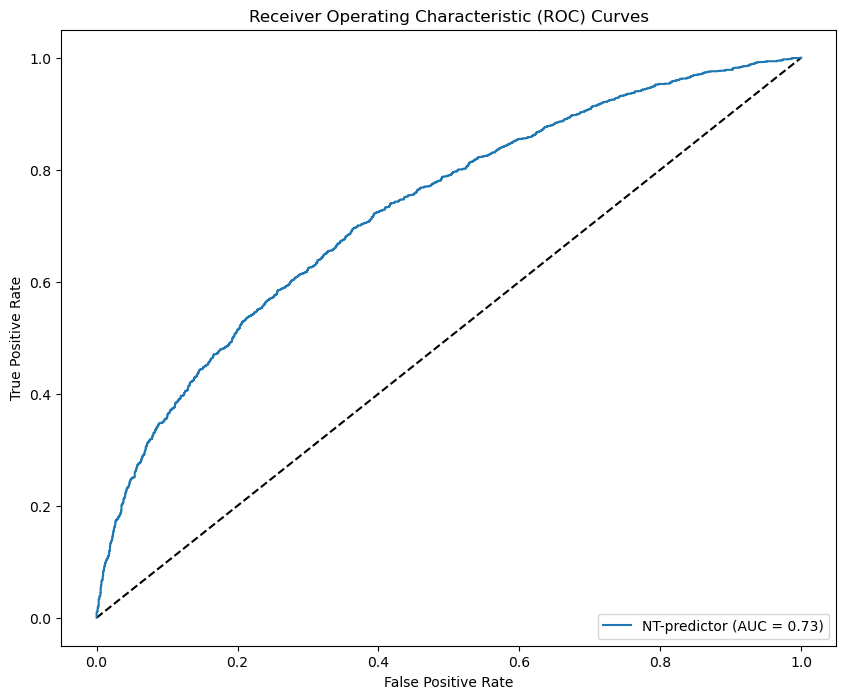

In [27]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT-predictor'}], ephnen_sampled.ground_truth)

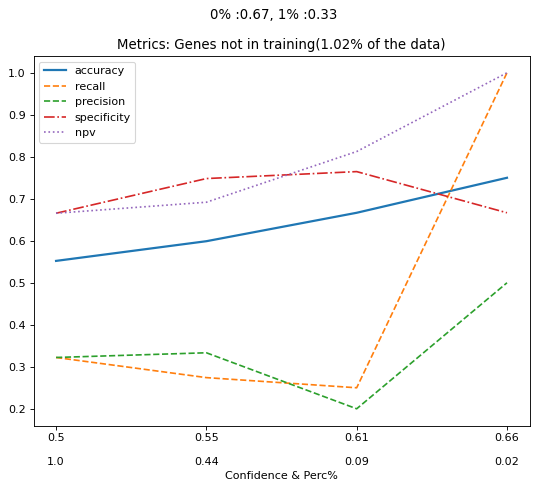

In [28]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

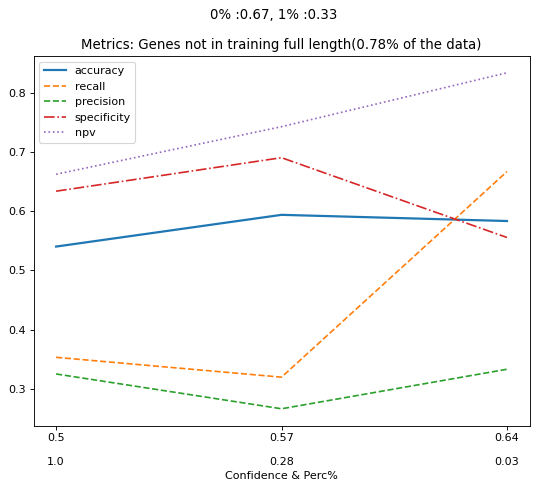

In [29]:
not_in_train_fl = not_in_train[(not_in_train.original_length1 <= MAX_RNA_SIZE)&(not_in_train.original_length2 <= MAX_RNA_SIZE)]
not_in_train_fl = not_in_train_fl[(not_in_train_fl.policy == 'easypos')|(not_in_train_fl.policy == 'smartneg')]
obtain_plot(not_in_train_fl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training full length', n_conf = 8)

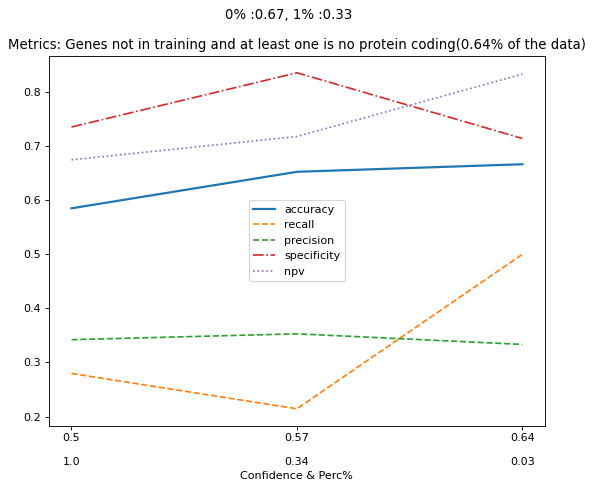

In [30]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

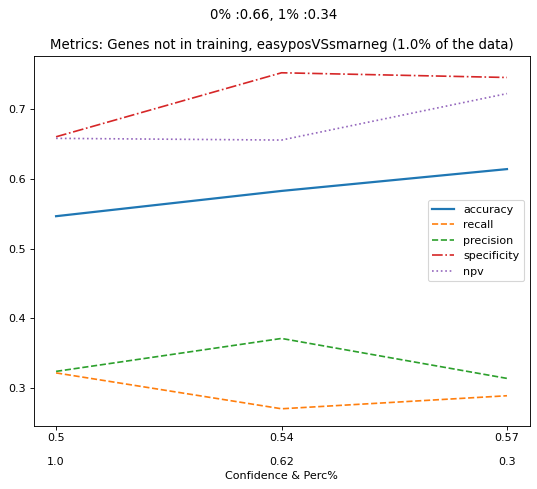

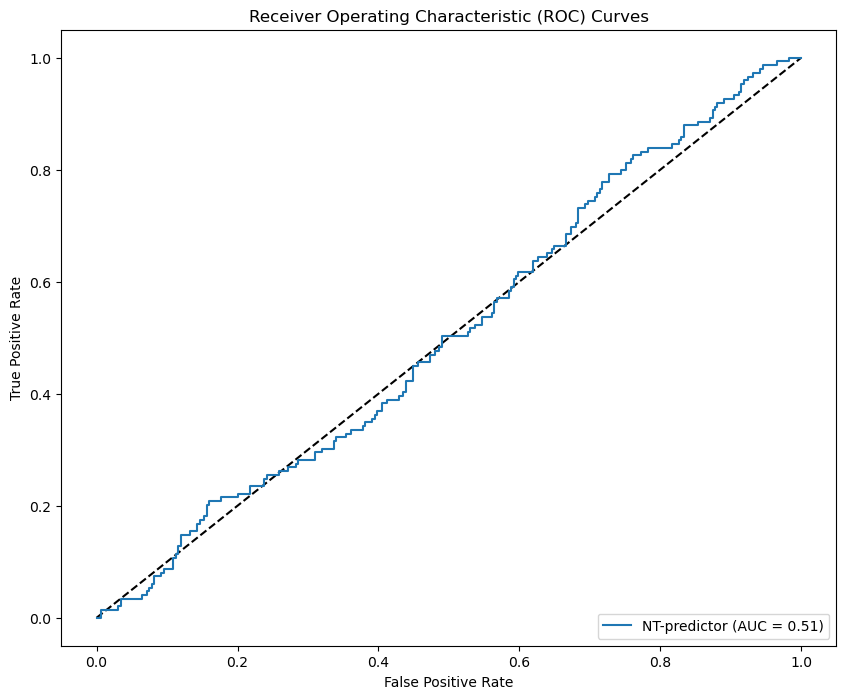

In [32]:
not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]
obtain_plot(not_in_train_epsn, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn.ground_truth)

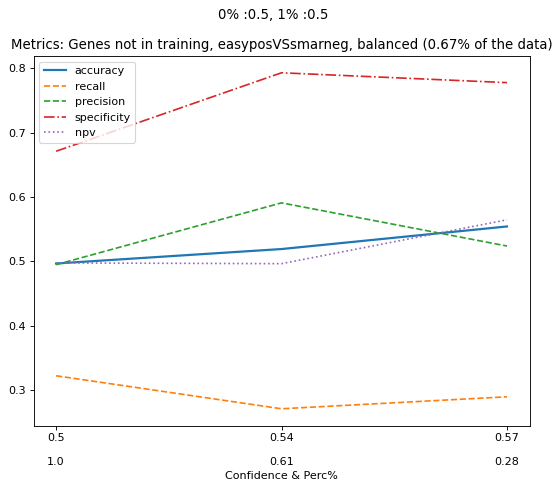

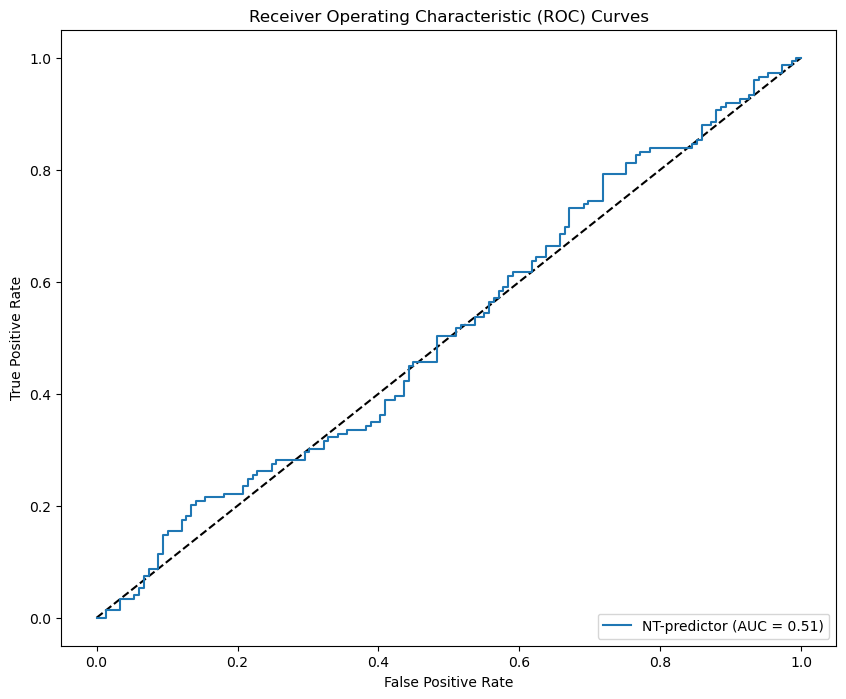

In [33]:
negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

not_in_train_epsn_balanced = pd.concat([negs.sample(len(poss)), poss], axis = 0)
obtain_plot(not_in_train_epsn_balanced, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg, balanced ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn_balanced.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn_balanced.ground_truth)

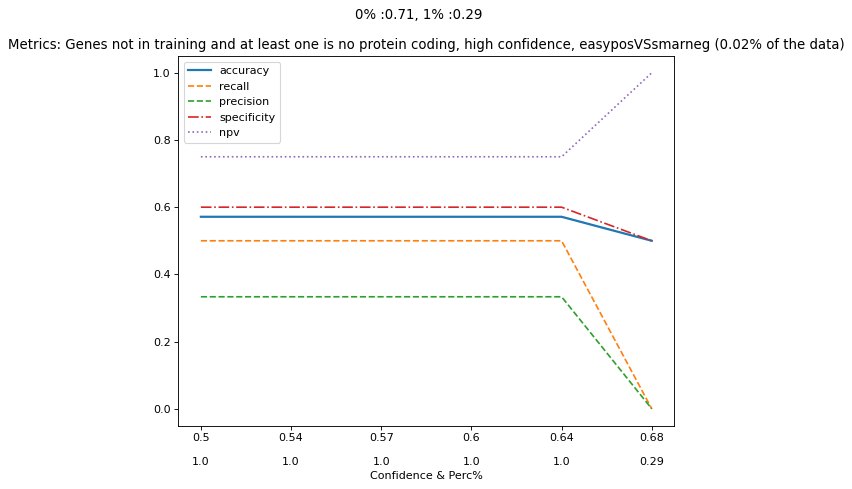

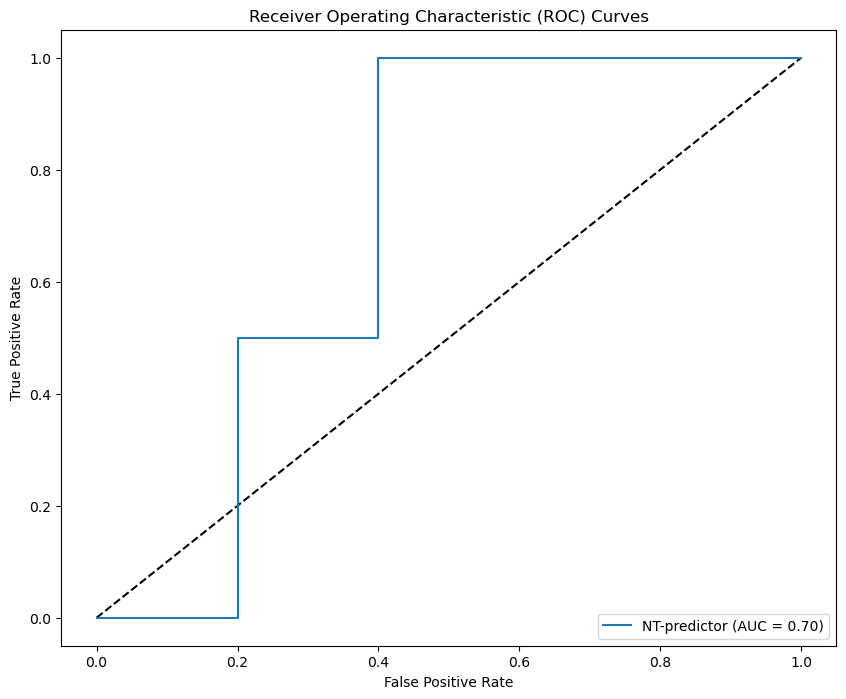

In [34]:
confidence_level = 0.65

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]
obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': no_pc_no_train.probability, 'model_name': 'NT-predictor'}], no_pc_no_train.ground_truth)

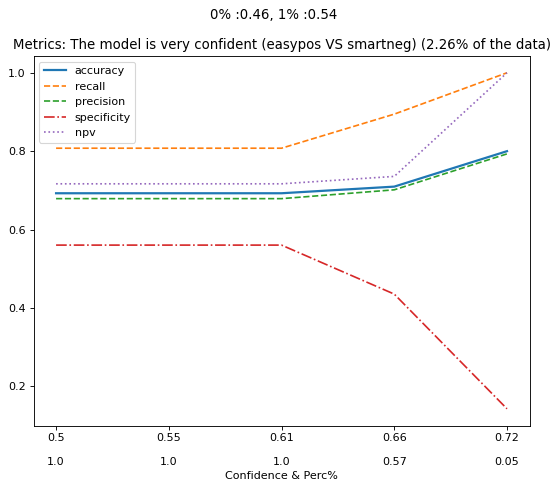

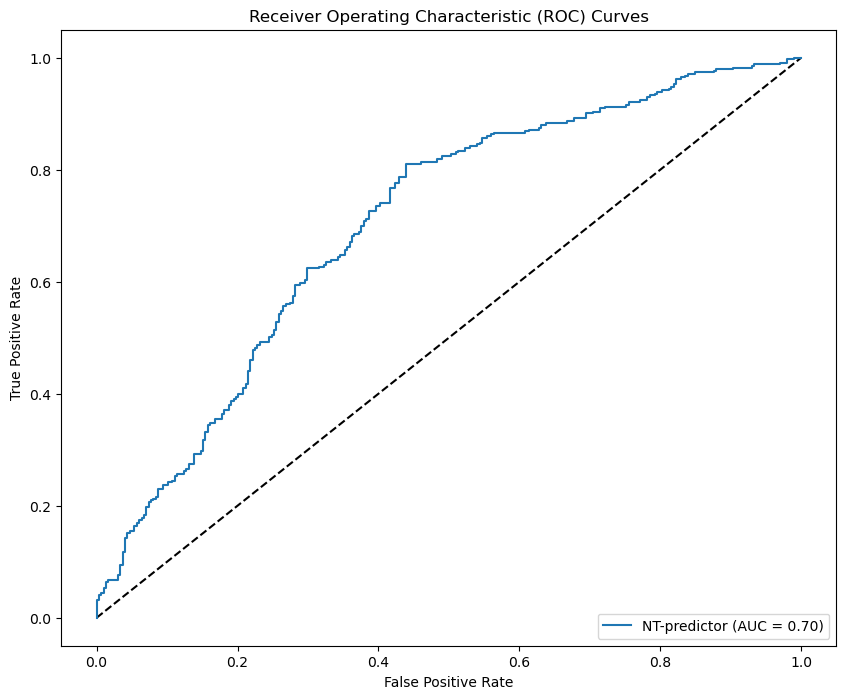

In [35]:
confidence_level = 0.65
high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

obtain_plot(high_prob_pairs, n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

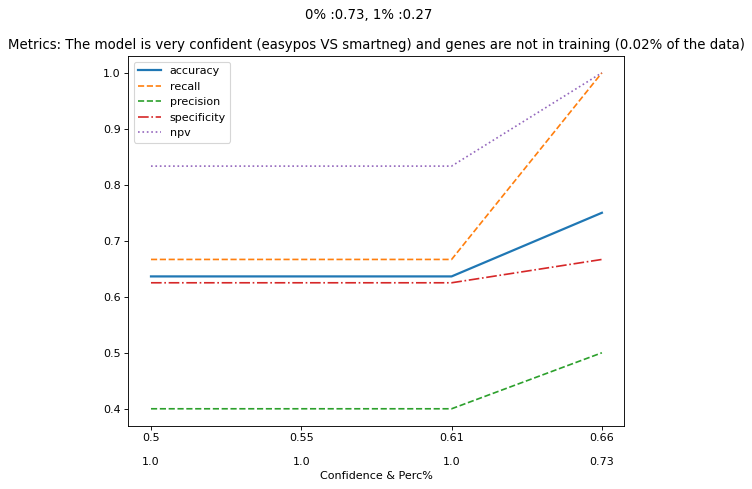

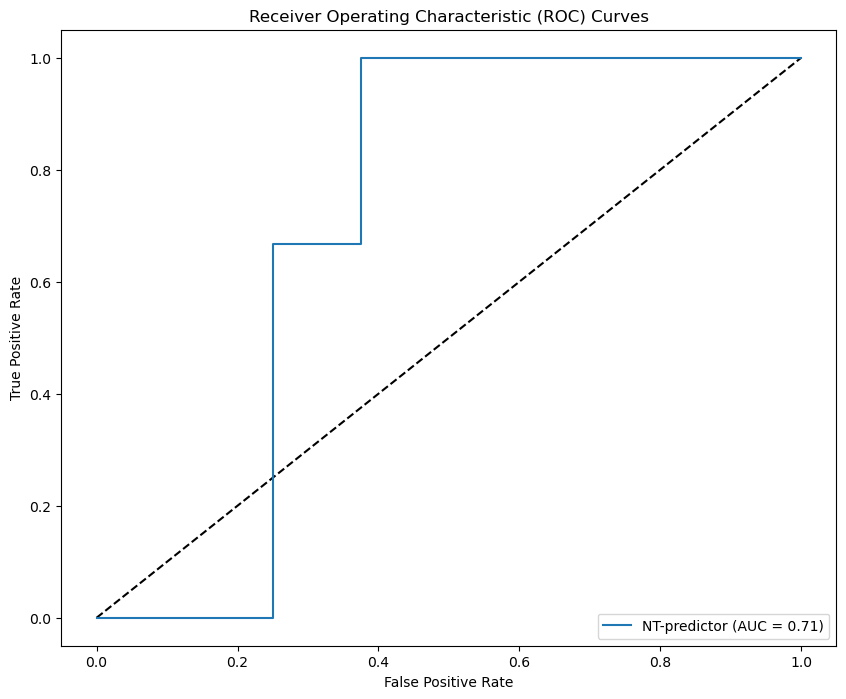

In [36]:
confidence_level = 0.65
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

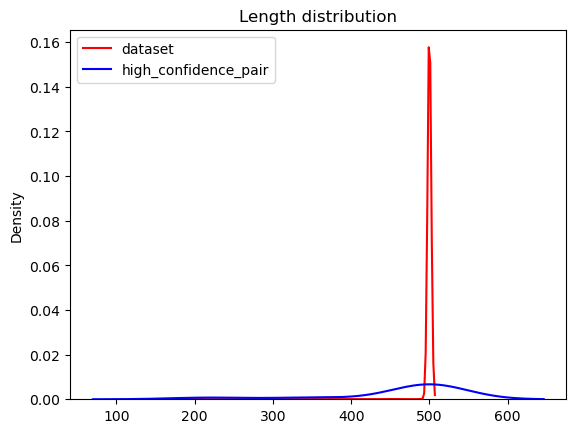

In [37]:
sns.kdeplot(list(pd.concat([easypos_smartneg.len_g1, easypos_smartneg.len_g2], axis = 0)), color = 'red', label = 'dataset')
sns.kdeplot(list(pd.concat([high_prob_pairs.len_g1, high_prob_pairs.len_g2], axis = 0)), color = 'blue', label = 'high_confidence_pair')
plt.title(f'Length distribution')
plt.legend()

# Compare with INTARNA

In [38]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'val500', 'val.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

In [39]:
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [40]:
intarna.shape[0]

44397

In [41]:
res.shape[0]

44397

In [42]:
auc_nt = []
auc_intarna = []

for i in range(500):
    # undersample 0 class
    res0 = res[res.ground_truth == 0]
    res1 = res[res.ground_truth == 1]
    balanced = pd.concat([res0.sample(res1.shape[0]), res1], axis = 0)

    fpr, tpr, _ = roc_curve(balanced.ground_truth, balanced.probability)
    roc_auc = auc(fpr, tpr)
    auc_nt.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(abs(1 - balanced.ground_truth), balanced.E_norm)
    roc_auc = auc(fpr, tpr)
    auc_intarna.append(roc_auc)

In [43]:
print(np.mean(auc_nt), 
      np.mean(auc_intarna)
     )

0.5777258848938702 0.5341373793394166


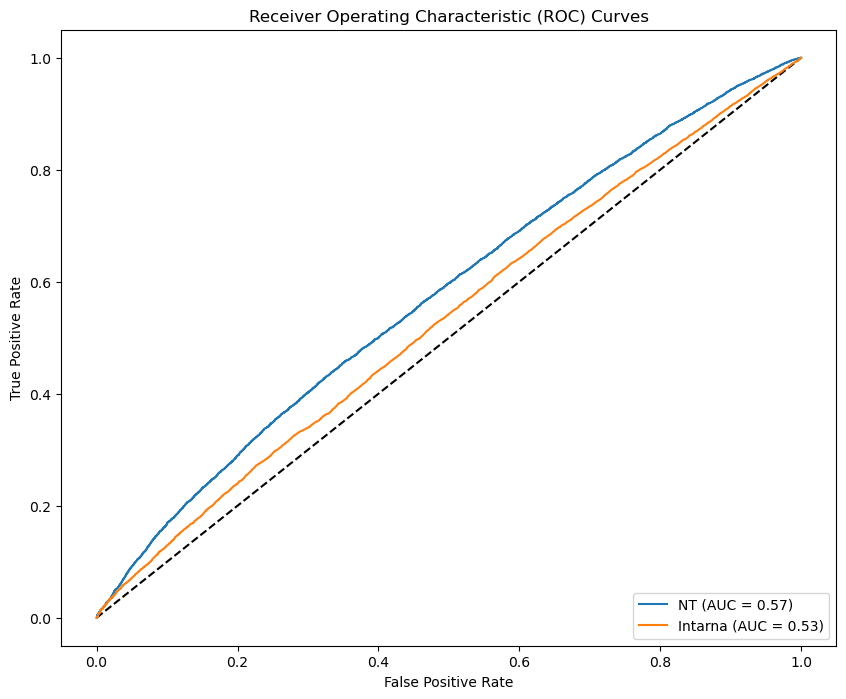

In [44]:
plot_roc_curves([{'prob': balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced.E_norm), 'model_name': 'Intarna'}
                ], balanced.ground_truth)

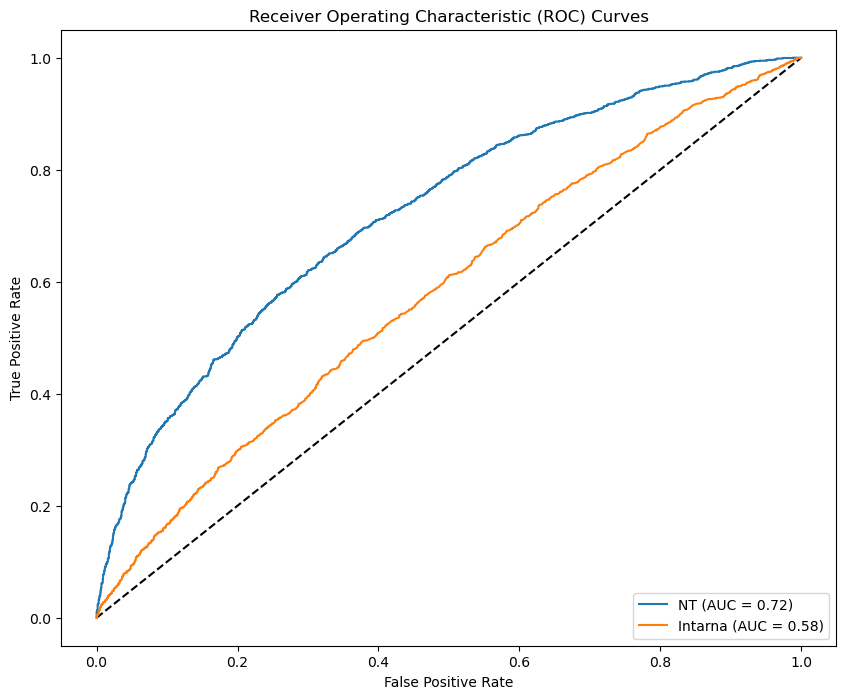

In [45]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

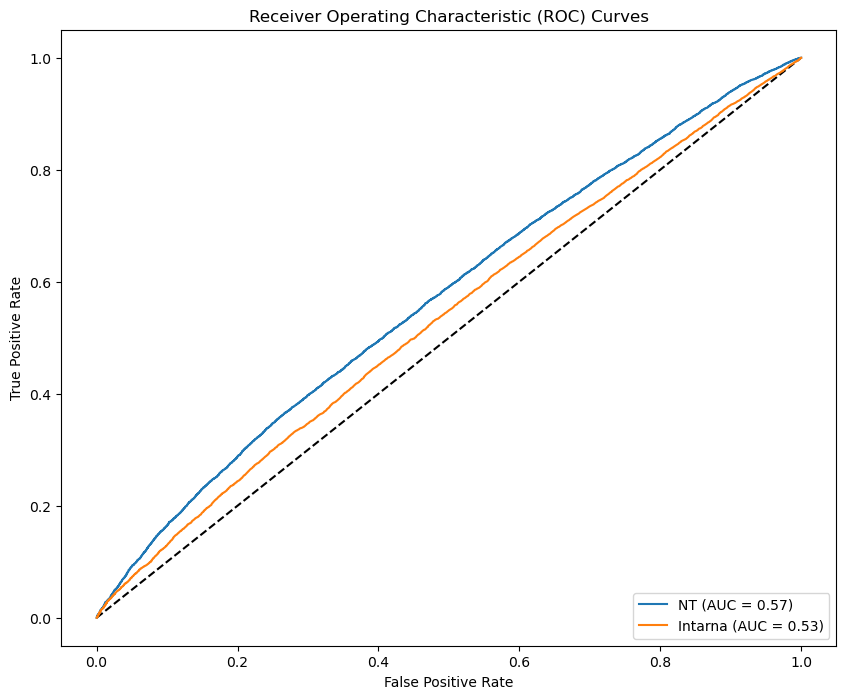

In [46]:
test = pd.read_csv(os.path.join(metadata_dir, f'val_sampled.csv'))
test = test[['id_gene1_sample', 'id_gene2_sample']]

res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg.ground_truth)

#### Compare AUC based on confidence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


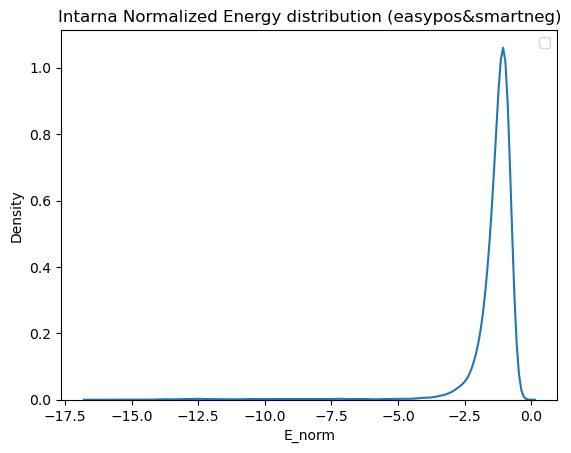

In [47]:
sns.kdeplot(easypos_smartneg.E_norm)
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

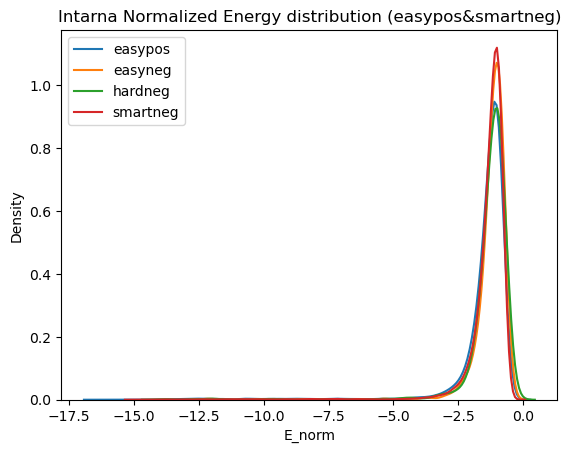

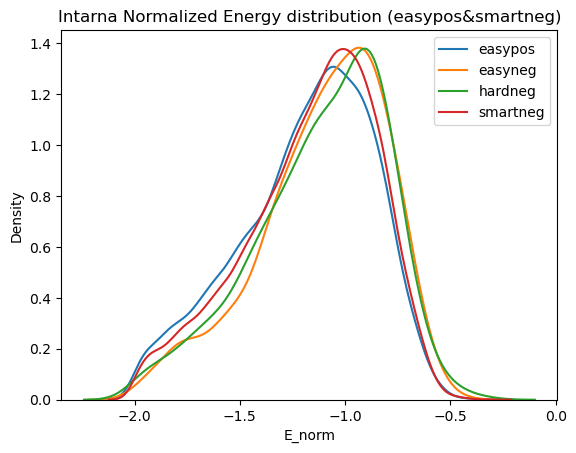

In [48]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [49]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  2.0 %


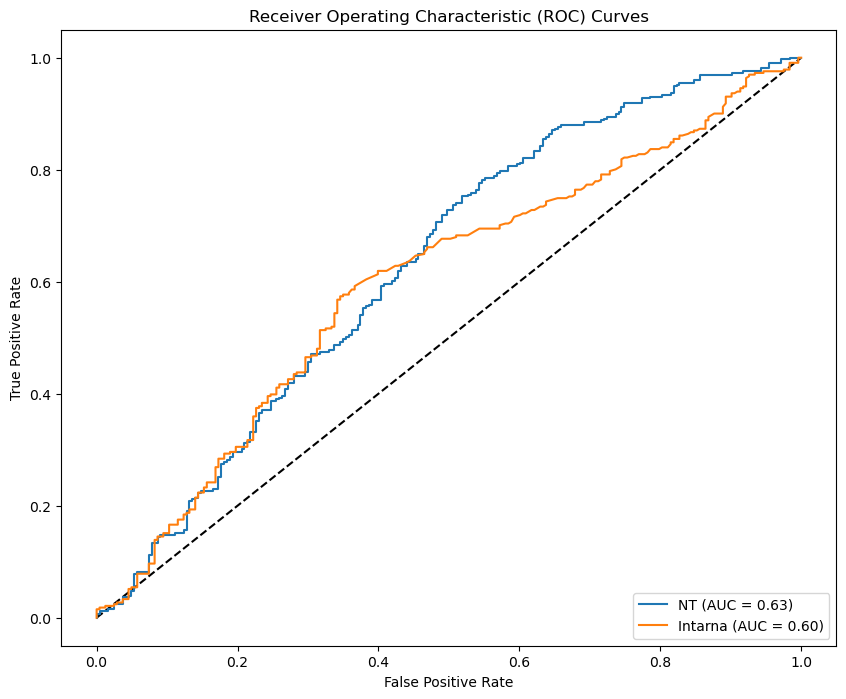

In [50]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.01)

perc of the total data:  0.3 %


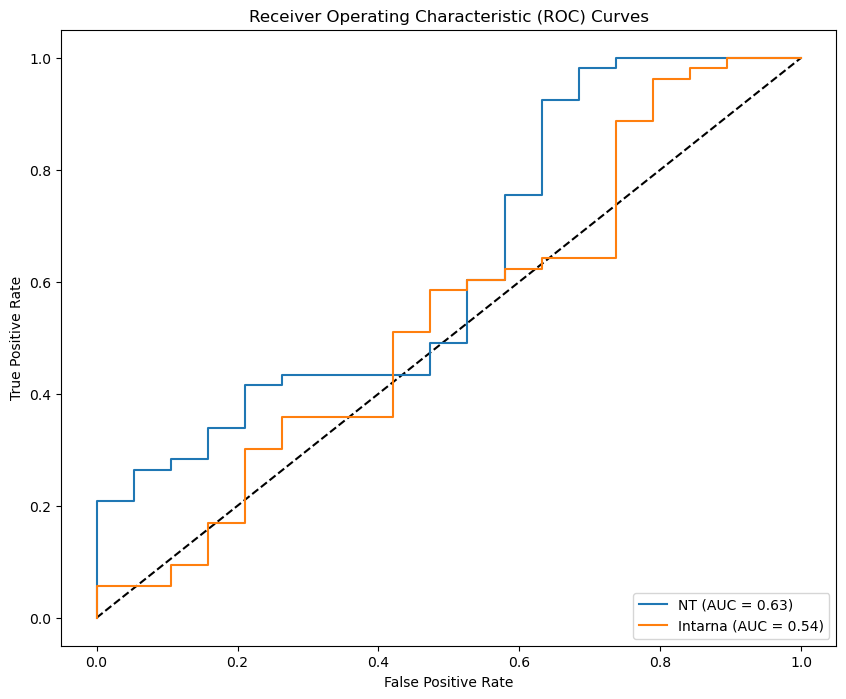

In [51]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.3)

Text(0.5, 0, 'Confidence & Perc%')

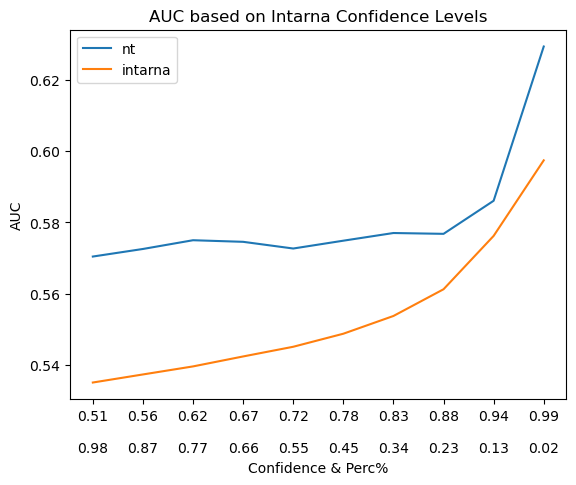

In [52]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

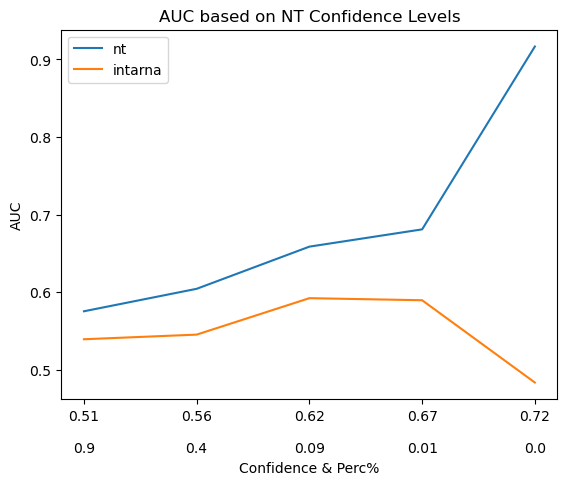

In [53]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

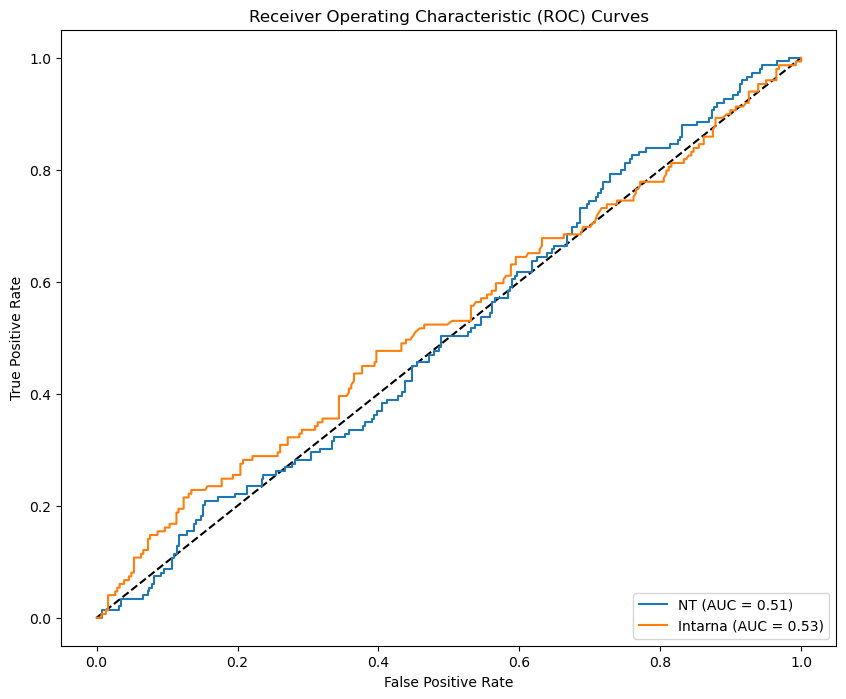

In [54]:
n_iters = 100

lists = []

for i in range(n_iters):

    not_in_train_epsn = easypos_smartneg[~(easypos_smartneg.gene1_original.isin(df_train_genes) | easypos_smartneg.gene2_original.isin(df_train_genes))]

    negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
    poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

    not_in_train_epsn = pd.concat([negs.sample(len(poss)), poss], axis = 0)
    lists.append(not_in_train_epsn)

not_in_train_epsn = pd.concat(lists, axis = 0)

plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(not_in_train_epsn.E_norm), 'model_name': 'Intarna'}
                ], not_in_train_epsn.ground_truth)

In [55]:
treshold = 0.7
subset_where_disagree = easypos_smartneg[
                (easypos_smartneg.probability >= treshold)|
                (easypos_smartneg.probability <= (1-treshold))
            ]

In [56]:
subset_where_disagree.ground_truth.value_counts()

1    53
0    19
Name: ground_truth, dtype: int64

### Estimate bias due to genes degree. PT1

In [147]:
# diff = df_nt[['couples_id', 'diff1', 'diff2']].dropna()
# new_cols = diff.couples_id.str.extractall('(.*)_(.*)').reset_index()
# diff['gene1'] = new_cols[0]
# diff['gene2'] = new_cols[1]
# diff = pd.concat([
#     diff[['gene1', 'diff1']].rename({'gene1':'gene', 'diff1':'diff'}, axis = 1),
#     diff[['gene2', 'diff2']].rename({'gene2':'gene', 'diff2':'diff'}, axis = 1)
# ], axis = 0)
# gb = diff.groupby('gene').std()
# assert gb[gb['diff'] >= 0.001].shape[0] == 0
# diff = diff.drop_duplicates('gene')
# diff['abs_diff'] = abs(diff['diff'])

In [148]:
# subset_where_disagree = subset_where_disagree.merge(diff, how = 'left', left_on = 'gene1_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff1'}, axis = 1)
# subset_where_disagree = subset_where_disagree.merge(diff, how = 'left', left_on = 'gene2_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff2'}, axis = 1)
# subset_where_disagree['diff1'] = subset_where_disagree['diff1'].fillna(0)
# subset_where_disagree['diff2'] = subset_where_disagree['diff2'].fillna(0)
# subset_where_disagree['sum_diff'] = subset_where_disagree['diff1'] + subset_where_disagree['diff2']

In [149]:
# quantile_level = 0.95

# problematic_genes = set(diff[diff.abs_diff> diff.abs_diff.quantile(quantile_level)].gene)

# print('the percentage of problematic genes is:', np.round(len(problematic_genes)/diff.shape[0] * 100, 2))

# perc = subset_where_disagree[
#     subset_where_disagree.gene1_original.isin(problematic_genes)|
#     subset_where_disagree.gene2_original.isin(problematic_genes)
# ].shape[0]/subset_where_disagree.shape[0]

# print('percentage of pairs belonging to problematic genes: ', np.round(perc*100, 2))

In [150]:
# perc = subset_where_disagree[
#     ((subset_where_disagree['sum_diff'] >= 0) & (subset_where_disagree['prediction'] == 0))|
#     ((subset_where_disagree['sum_diff'] <= 0) & (subset_where_disagree['prediction'] == 1))
# ].shape[0]/subset_where_disagree.shape[0]

# print('The percentage of pairs where the model predicts the sum of the degrees is: ', np.round(perc*100, 2))

### Estimate bias due to genes degree. PT2

In [151]:
# easypos_smartneg_sampled = easypos_smartneg_sampled.merge(diff, how = 'left', left_on = 'gene1_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff1'}, axis = 1)
# easypos_smartneg_sampled = easypos_smartneg_sampled.merge(diff, how = 'left', left_on = 'gene2_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff2'}, axis = 1)
# easypos_smartneg_sampled['diff1'] = easypos_smartneg_sampled['diff1'].fillna(0)
# easypos_smartneg_sampled['diff2'] = easypos_smartneg_sampled['diff2'].fillna(0)
# easypos_smartneg_sampled['sum_diff'] = easypos_smartneg_sampled['diff1'] + easypos_smartneg_sampled['diff2']
# easypos_smartneg_sampled['abs_sum_diff'] = abs(easypos_smartneg_sampled['sum_diff'])

In [152]:
# acc = []
# degree = []

# n_values = 250
# linspace = np.linspace(0.01, easypos_smartneg_sampled.abs_sum_diff.max() + 1, n_values)
# for i in range(n_values):
#     subset = easypos_smartneg_sampled[easypos_smartneg_sampled.abs_sum_diff<linspace[i]]
#     #subset = subset[subset.probability>0.7]
#     accuracy = subset[subset.ground_truth == subset.prediction].shape[0]/subset.shape[0]
#     acc.append(accuracy)
#     degree.append(linspace[i])

In [153]:
# plt.plot(degree, acc)
# plt.title('Accuracy based on degree unbalancing Levels')
         
# plt.ylabel('Accuracy')
# plt.xlabel('Unbalancing level')

# XAI

In [90]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))

        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb, :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)

        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height, width)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        ''.join(['C'for i in range(width)]), 
        ''.join(['C'for i in range(height)]), 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [57]:
xai = pd.read_csv(os.path.join(checkpoint_dir, 'gradcam_results500.csv'))

In [58]:
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [59]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0061
iou_value_tr: 0.0055
iou_value_rand: 0.0031


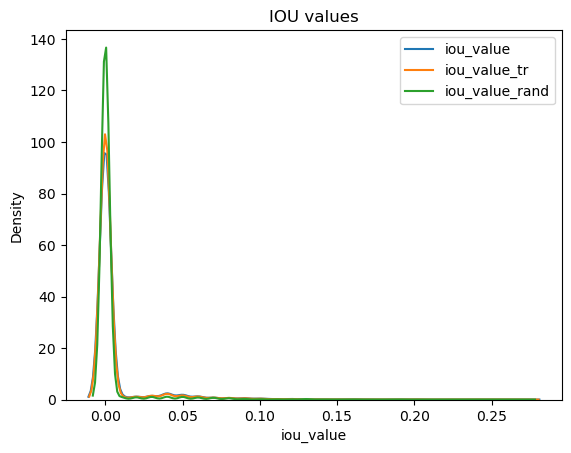

intensity: 0.5068
intensity_tr: 0.169
intensity_rand: 0.5


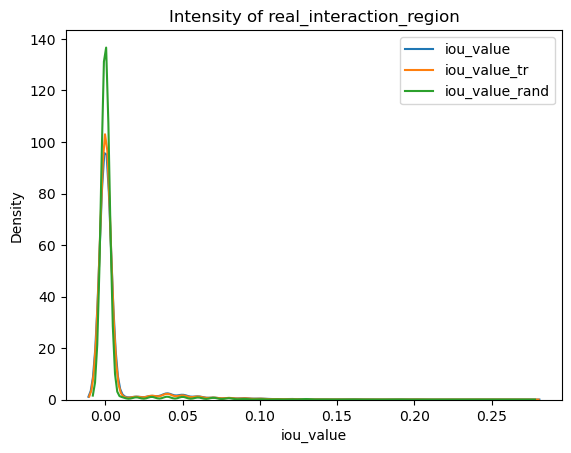

euclidean: 0.4591
euclidean_rand: 0.5298
euclidean_bbox_tr: 0.4975


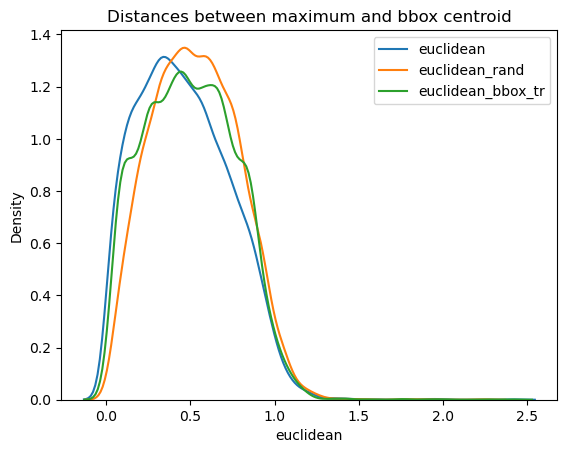

cos_sim: 0.06
cos_sim_tr: 0.04
cos_sim_rand: 0.04


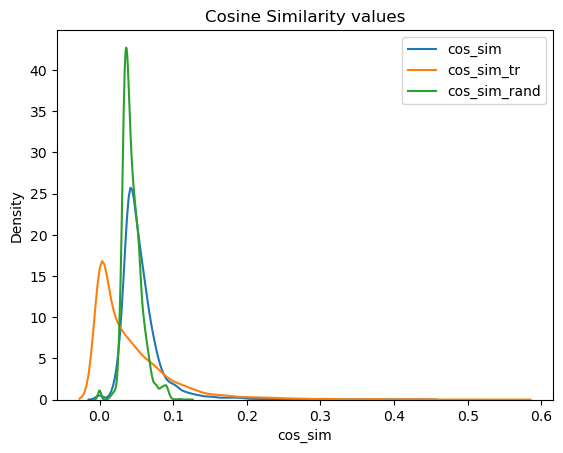

In [60]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

In [61]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

euclidean: 0.4287
euclidean_rand: 0.5974


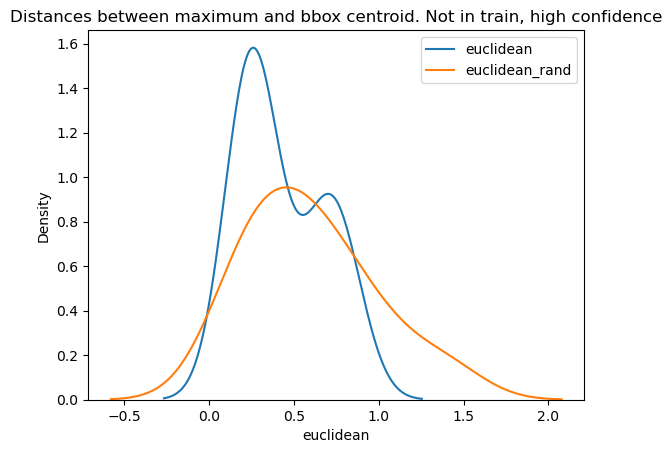

In [62]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.65)&(gradcam_results.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Not in train, high confidence')
plt.legend()
plt.show()

In [88]:
def plot_query_results_mod(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))

        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb, :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)

        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        
        print(x1, x2, y1, y2)

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height, width)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        ''.join(['C'for i in range(width)]), 
        ''.join(['C'for i in range(height)]), 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

prob: tensor([0.6964], grad_fn=<SelectBackward0>)
452 470 172 206


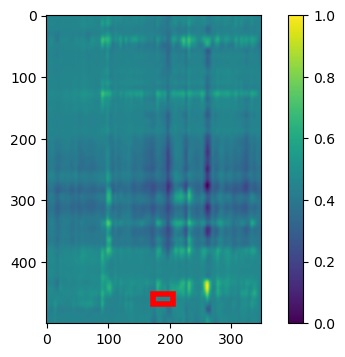

In [89]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results_mod(pd.DataFrame(query.iloc[7:8]))

prob: tensor([0.7836], grad_fn=<SelectBackward0>)


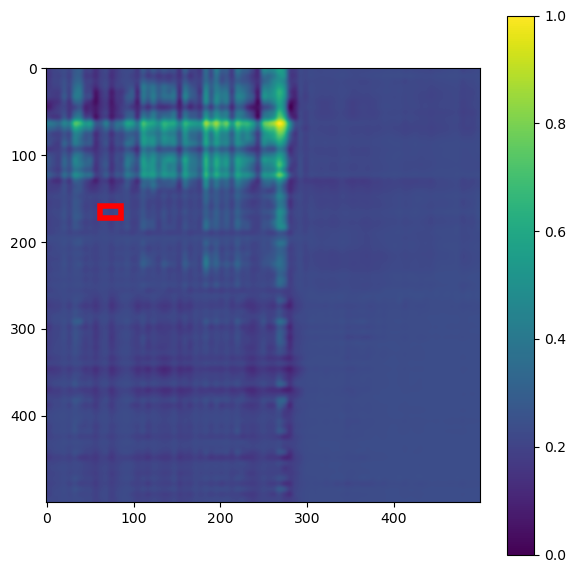

prob: tensor([0.7334], grad_fn=<SelectBackward0>)


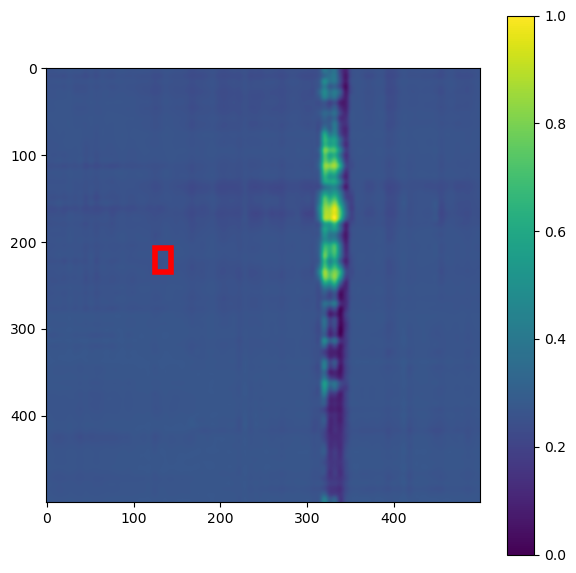

prob: tensor([0.6547], grad_fn=<SelectBackward0>)


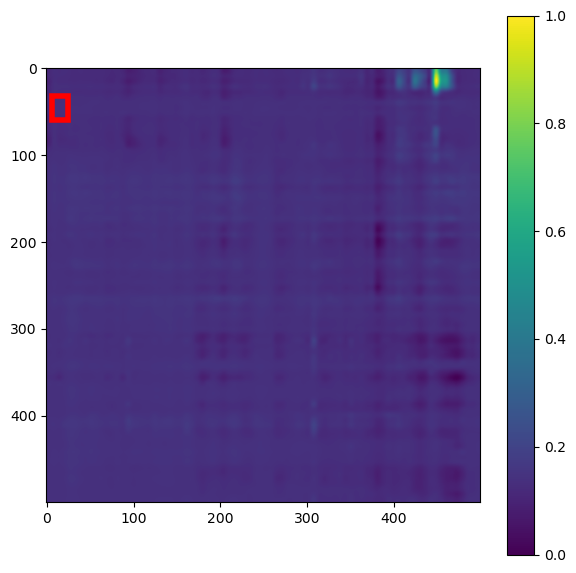

prob: tensor([0.7686], grad_fn=<SelectBackward0>)


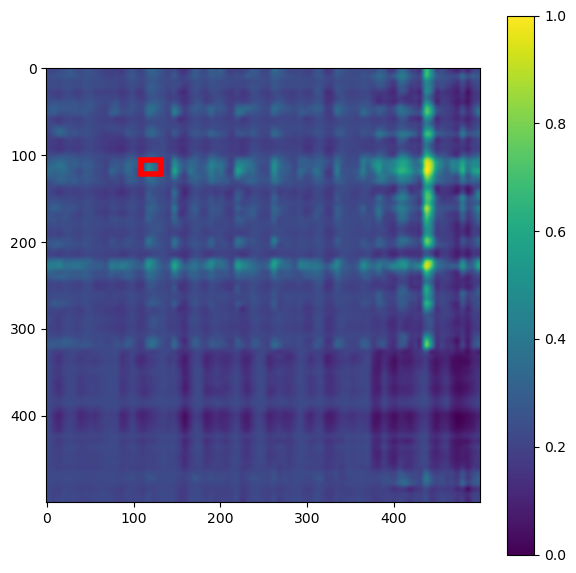

prob: tensor([0.7563], grad_fn=<SelectBackward0>)


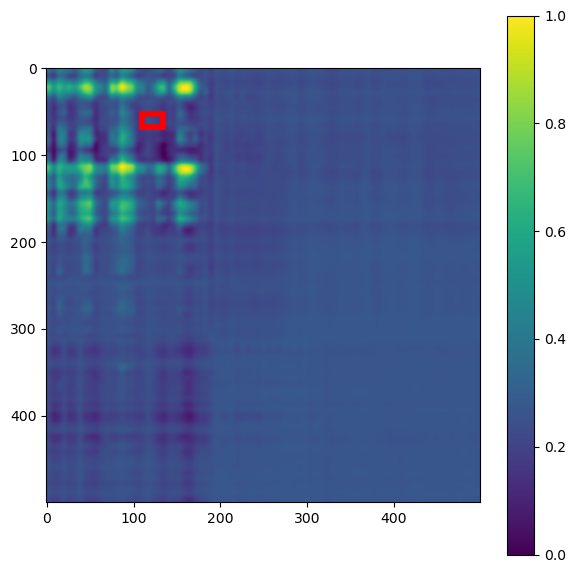

prob: tensor([0.7764], grad_fn=<SelectBackward0>)


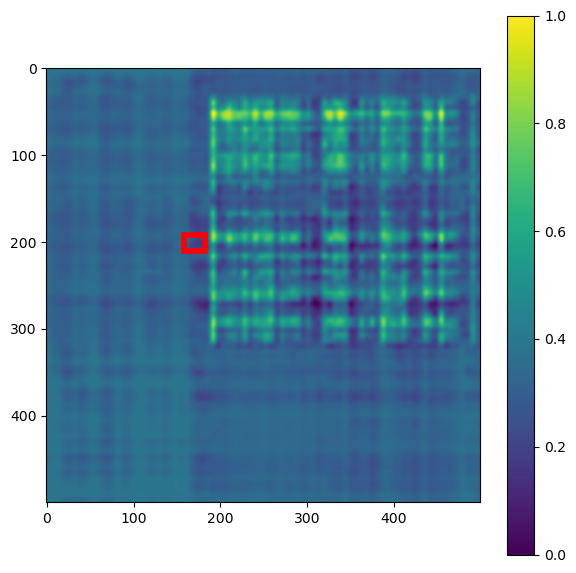

prob: tensor([0.7063], grad_fn=<SelectBackward0>)


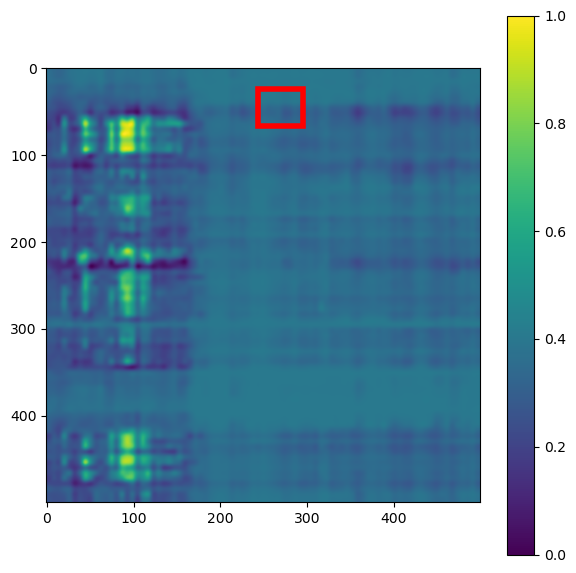

prob: tensor([0.6964], grad_fn=<SelectBackward0>)


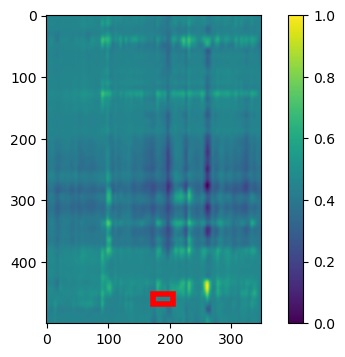

prob: tensor([0.6600], grad_fn=<SelectBackward0>)


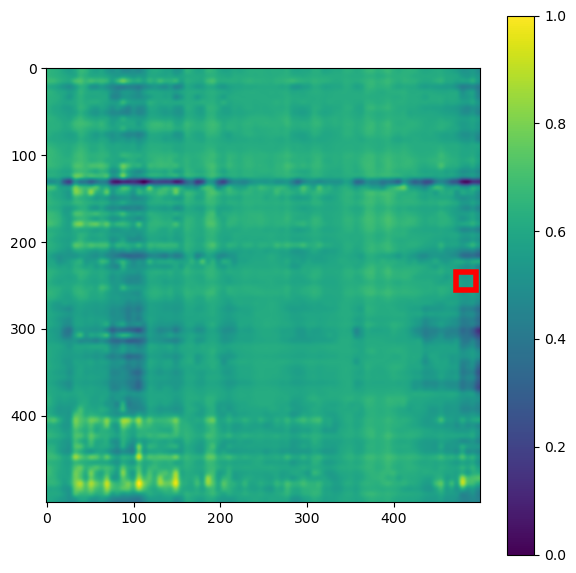

prob: tensor([0.6530], grad_fn=<SelectBackward0>)


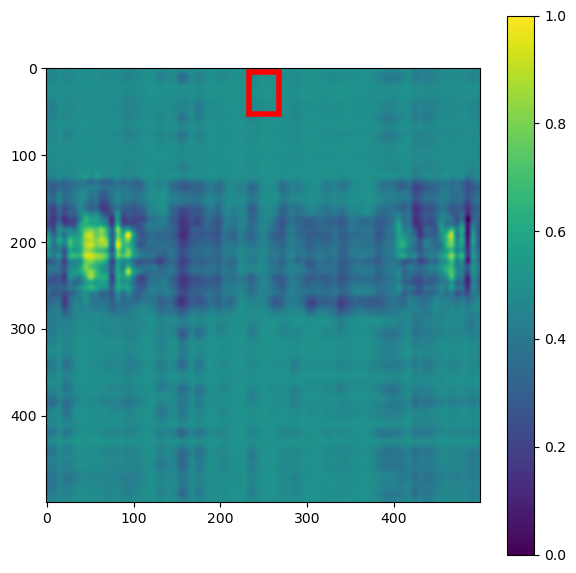

prob: tensor([0.7184], grad_fn=<SelectBackward0>)


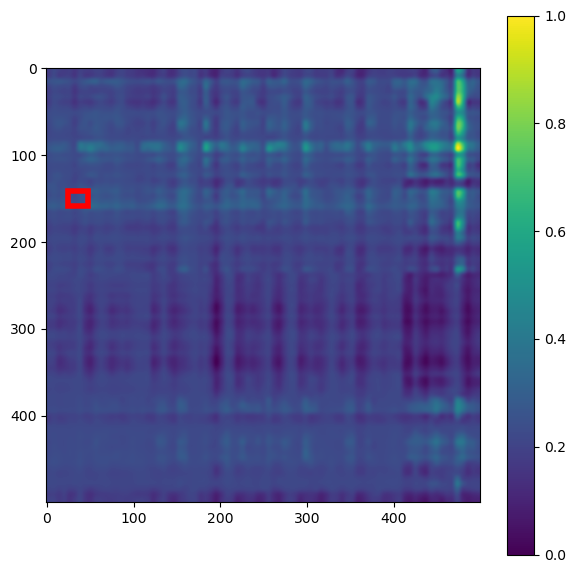

In [91]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query)

euclidean: 0.3549
euclidean_rand: 0.5099


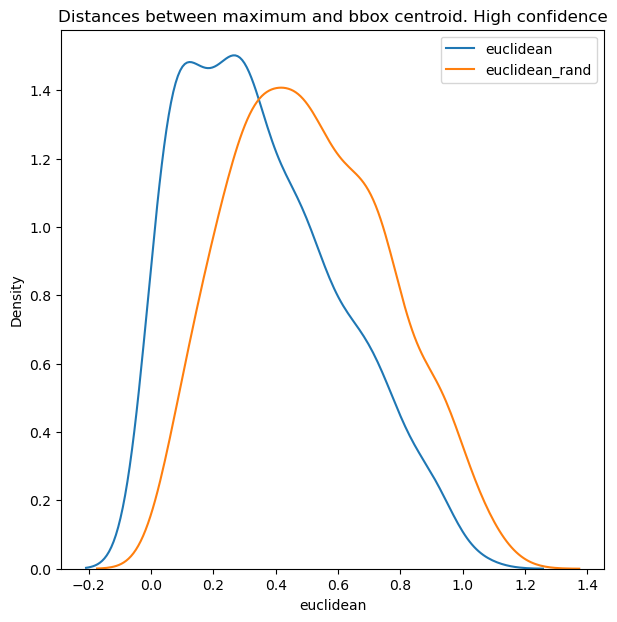

In [92]:
gradcam_results = xai[(xai.probability>0.75)&(xai.probability<0.79)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

prob: tensor([0.7892], grad_fn=<SelectBackward0>)


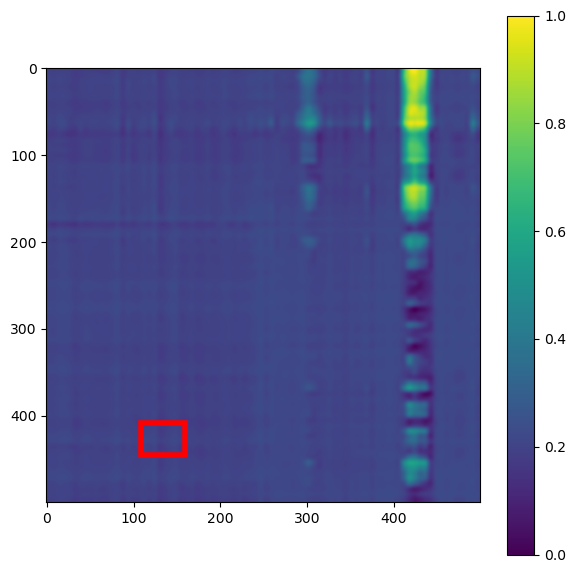

prob: tensor([0.7882], grad_fn=<SelectBackward0>)


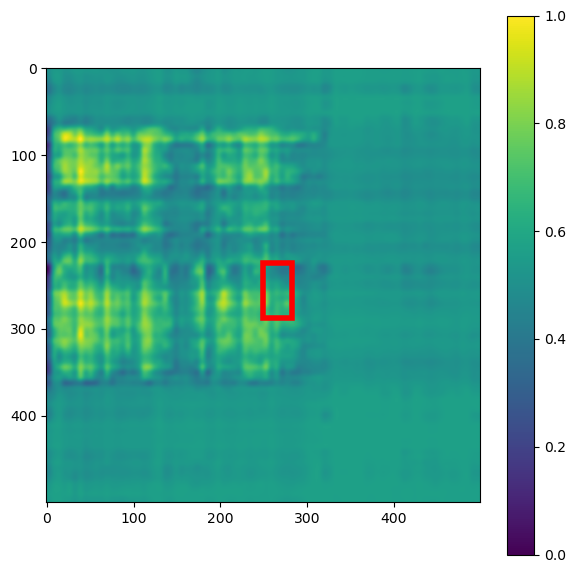

prob: tensor([0.7620], grad_fn=<SelectBackward0>)


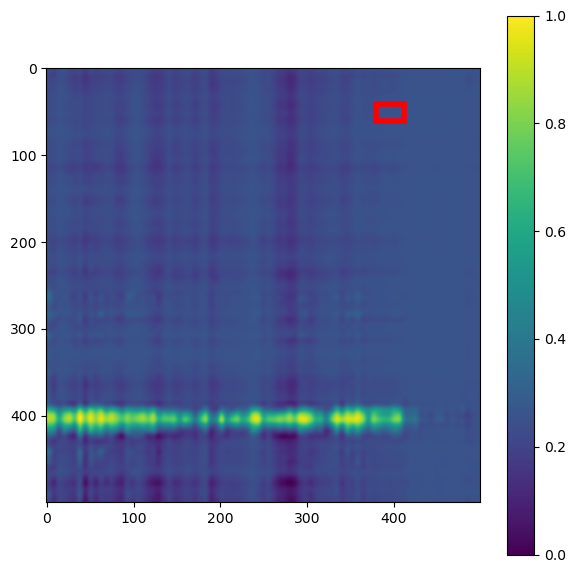

prob: tensor([0.7862], grad_fn=<SelectBackward0>)


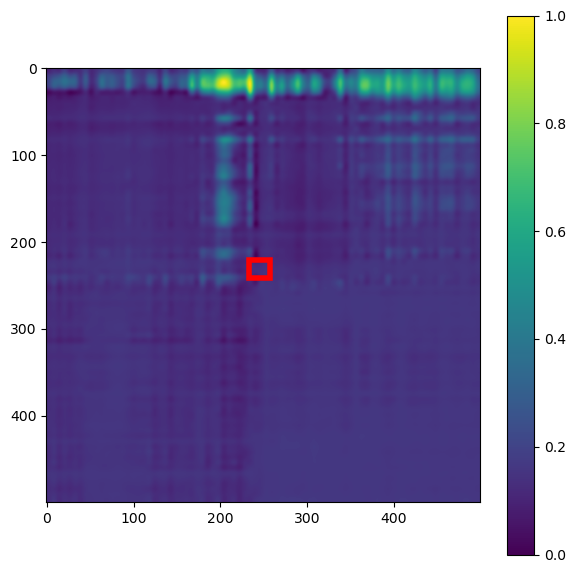

prob: tensor([0.7842], grad_fn=<SelectBackward0>)


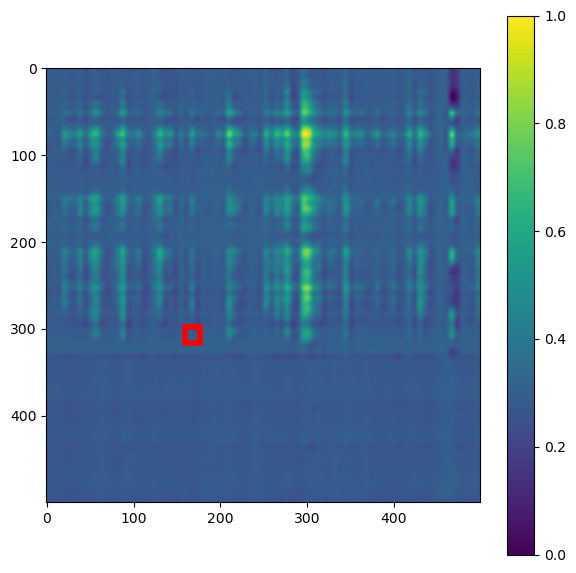

prob: tensor([0.7832], grad_fn=<SelectBackward0>)


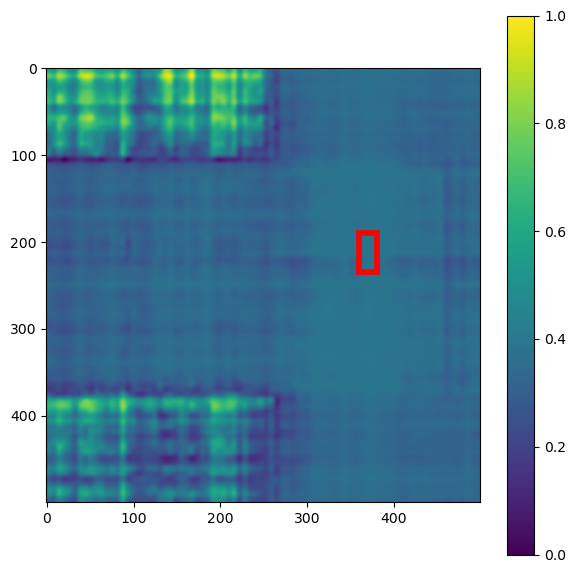

prob: tensor([0.7619], grad_fn=<SelectBackward0>)


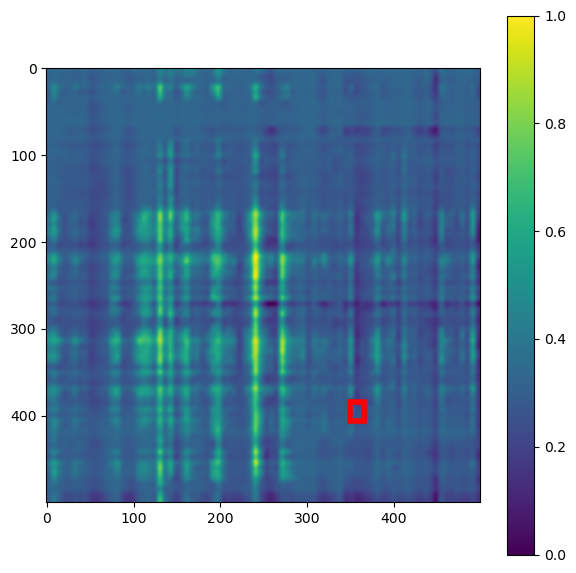

prob: tensor([0.7749], grad_fn=<SelectBackward0>)


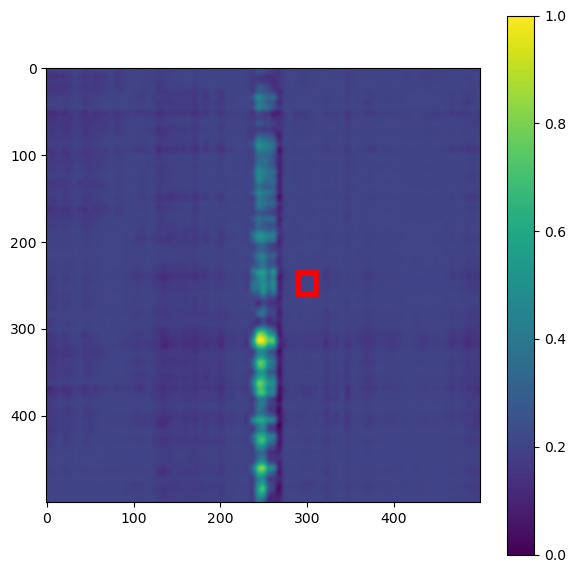

prob: tensor([0.7678], grad_fn=<SelectBackward0>)


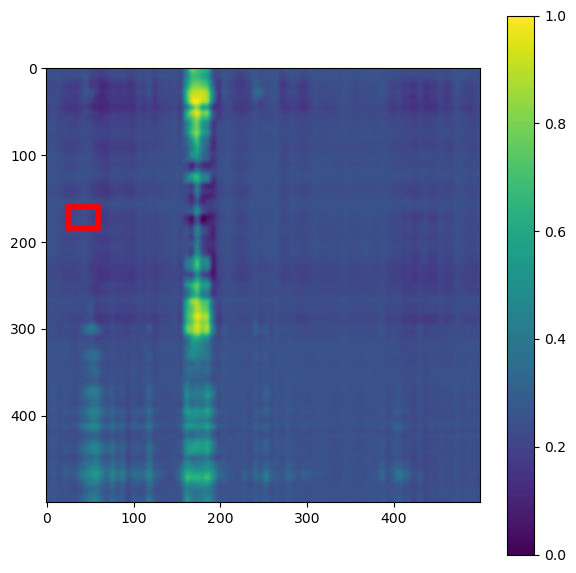

prob: tensor([0.7514], grad_fn=<SelectBackward0>)


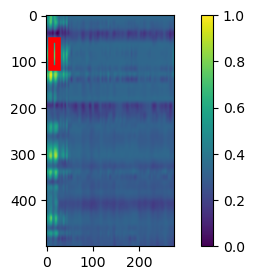

prob: tensor([0.7729], grad_fn=<SelectBackward0>)


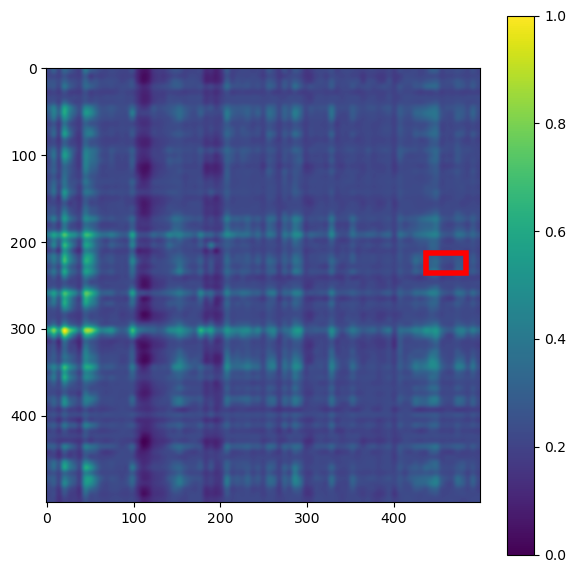

prob: tensor([0.7716], grad_fn=<SelectBackward0>)


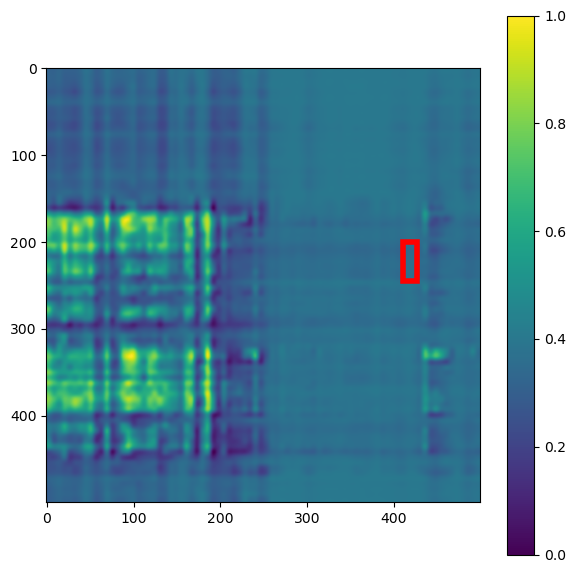

prob: tensor([0.7627], grad_fn=<SelectBackward0>)


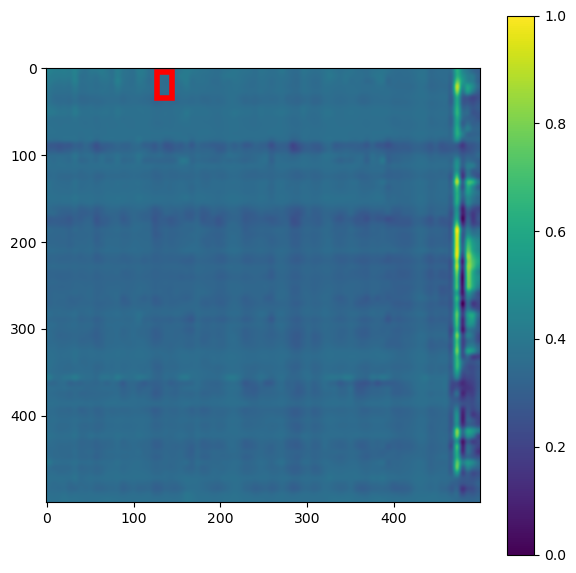

prob: tensor([0.7844], grad_fn=<SelectBackward0>)


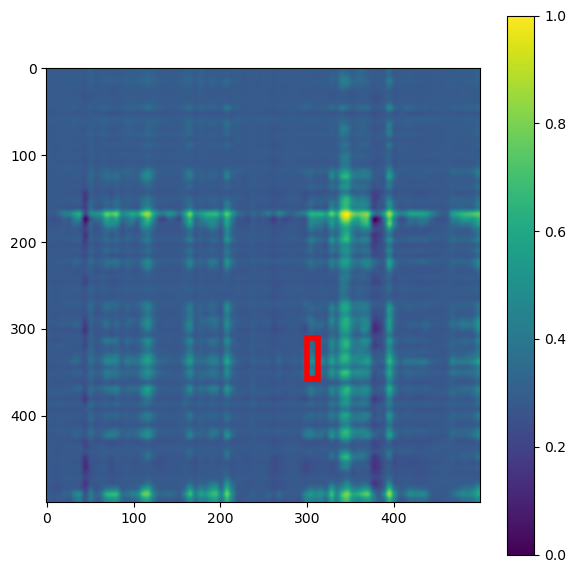

prob: tensor([0.7820], grad_fn=<SelectBackward0>)


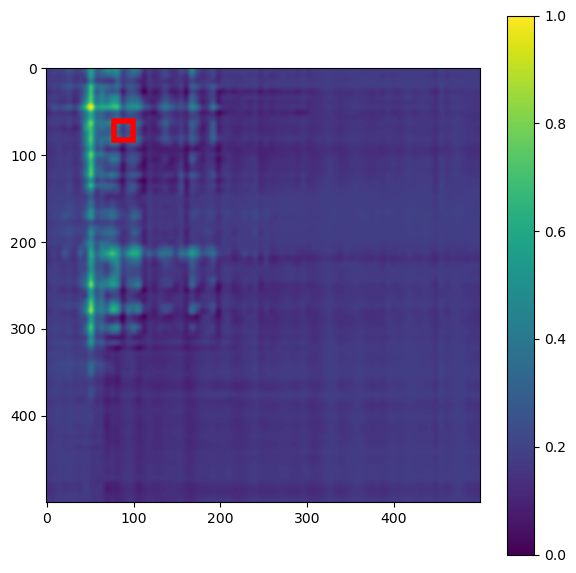

prob: tensor([0.7873], grad_fn=<SelectBackward0>)


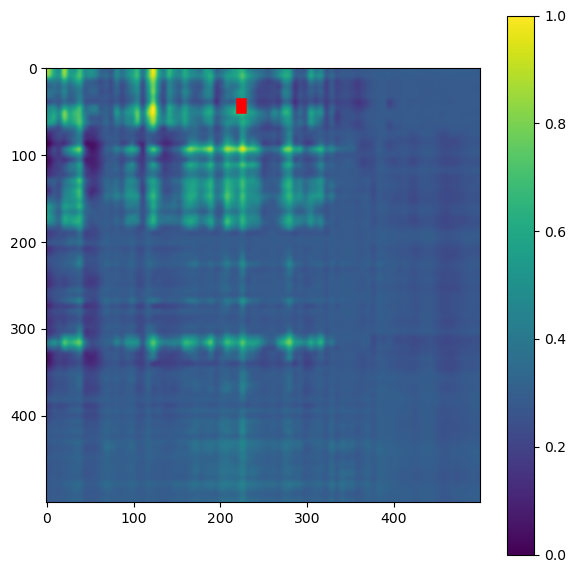

prob: tensor([0.7681], grad_fn=<SelectBackward0>)


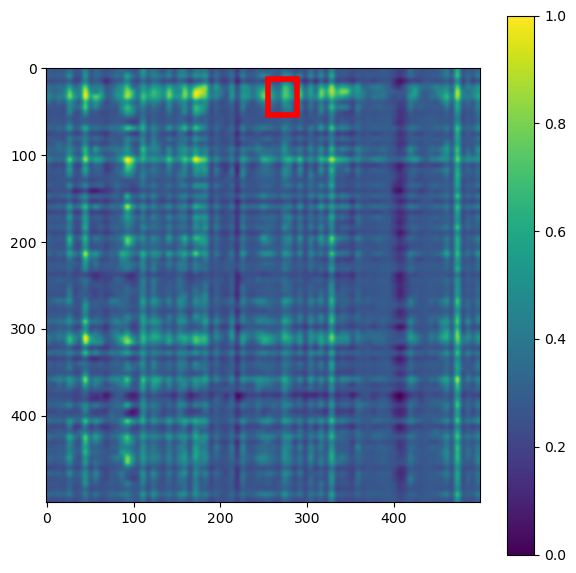

prob: tensor([0.7860], grad_fn=<SelectBackward0>)


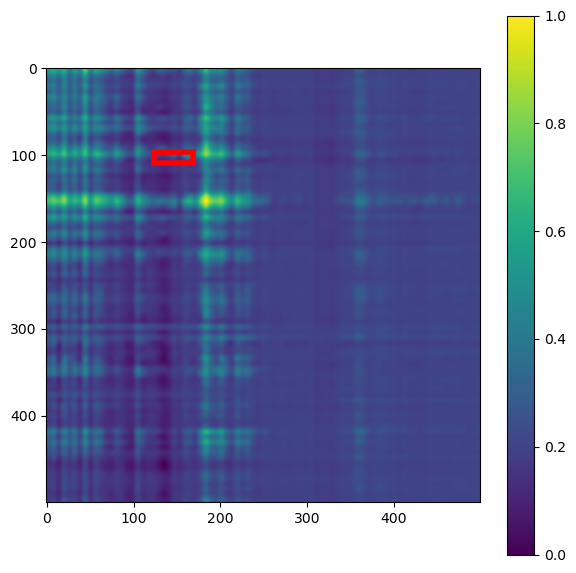

prob: tensor([0.7838], grad_fn=<SelectBackward0>)


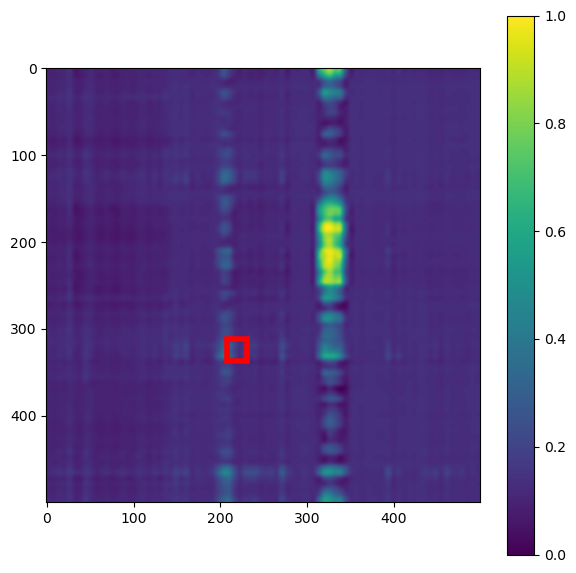

prob: tensor([0.7573], grad_fn=<SelectBackward0>)


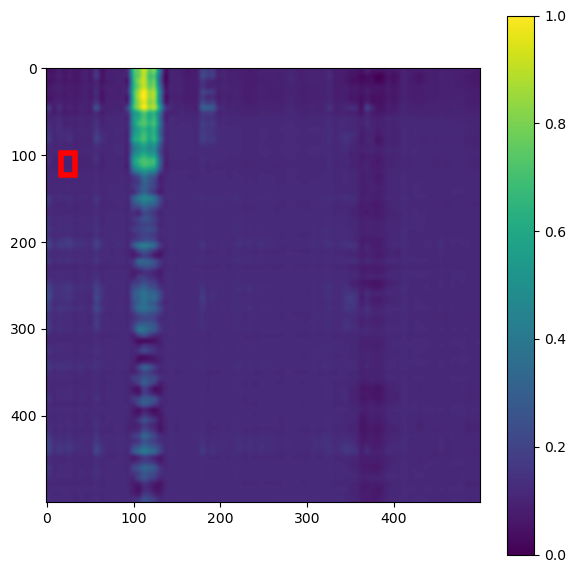

prob: tensor([0.7780], grad_fn=<SelectBackward0>)


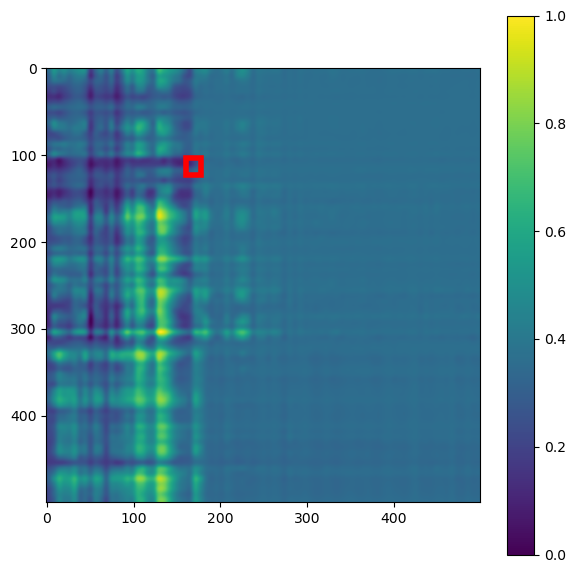

prob: tensor([0.7531], grad_fn=<SelectBackward0>)


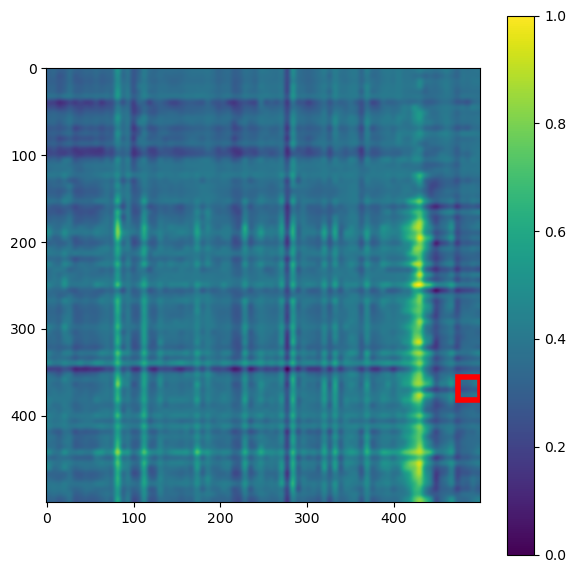

prob: tensor([0.7881], grad_fn=<SelectBackward0>)


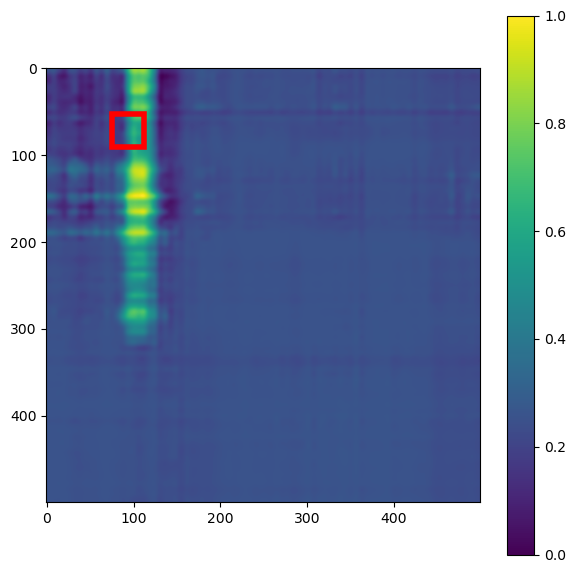

prob: tensor([0.7746], grad_fn=<SelectBackward0>)


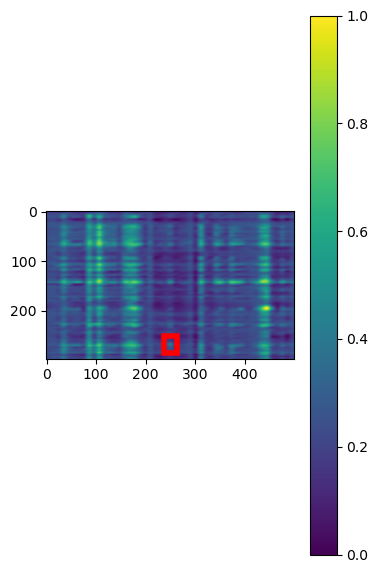

prob: tensor([0.7550], grad_fn=<SelectBackward0>)


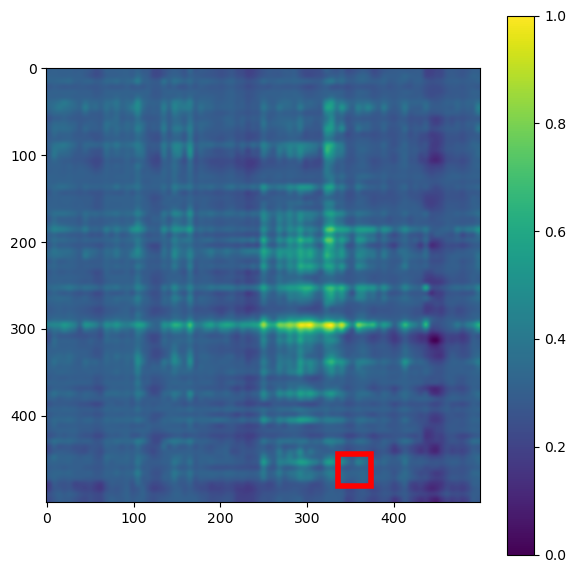

In [93]:
query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query = query.merge(diff, how = 'left', left_on = 'gene1_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff1'}, axis = 1)
# query = query.merge(diff, how = 'left', left_on = 'gene2_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff2'}, axis = 1)
# query['diff1'] = query['diff1'].fillna(0)
# query['diff2'] = query['diff2'].fillna(0)
# query['sum_diff'] = query['diff1'] + query['diff2']
# query['abs_sum_diff'] = abs(query['sum_diff'])
plot_query_results(query.head(25))

# Sistema sta cosa del plot SIA IN QUESTO NOTEBOOK CHE IN QUELLO DI TEST (CONTROLLA ANCHE CHE LA MAPPA SIA COERENTE CON LE SEQUENZE (CREATE_CONTACT_MATRIX FA QUELLO CHE MI ATTENDO?))

# TROVA UN MODO PER STIMARE BENE LA CORRELAZIONE TRA DEGREE E CONFIDENCE, ci servira per creare il regolarizzatore

# CREA SCRIPT PER DEFINIRE IL MIGLIOR MODELLO CONFRONTANDO I DATI DEL VALIDATION SET